In [1]:
from keras import backend as K
import tensorflow as tf
# with K.tf.device('/gpu:2'):
#     config = tf.ConfigProto(intra_op_parallelism_threads=1,\
#            inter_op_parallelism_threads=1, allow_soft_placement=True,\
#            device_count = {'CPU' : 1, 'GPU' : 1})
#     session = tf.Session(config=config)
#     K.set_session(session)

Using TensorFlow backend.


In [2]:
from keras.models import load_model
from hpa_src.data.datasets import readimg, HpaDataset, TestDataset

In [3]:
from torch.utils.data import DataLoader, random_split
from PIL import Image
from torchvision import transforms
from hpa_src.data.transforms import ToPIL, ToNumpy
from hpa_src.models.loss import CrossEntropyLossOneHot
import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

from hpa_src.models.metrics import f1

In [4]:
input_size = 299
train_transform = transforms.Compose([
    ToPIL(),
    #transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.1149, 0.0922, 0.0553),
                         (0.1694, 0.1381, 0.1551))
])
val_transform = transforms.Compose([
    ToPIL(),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize((0.1149, 0.0922, 0.0553),
                         (0.1694, 0.1381, 0.1551)),
    ToNumpy()
])

In [5]:
from hpa_src.config import get_data_dir
DATA = get_data_dir()
test = TestDataset(DATA + 'raw/sample_submission.csv', transform=val_transform)

In [6]:
from hpa_src.data.functional import array2str, preds2label

In [7]:
test_dl = DataLoader(test, batch_size=16, num_workers=8)

In [8]:
model = load_model('/data/nasif12/home_if12/chengju/project/HumanProteinAtlas/hpa_src/../data/../models/InceptionV3.h5', custom_objects={'f1':f1})

In [9]:
def to_numpy(dl):
    for item in dl:
        yield item.numpy()

In [10]:
prediction = model.predict_generator(to_numpy(test_dl), steps=len(test) / 16)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [12]:
def preds2label(preds, threshold=0):
    ''' Convert prediction to multilabel
    Args:
        preds: prediction, default logits
        threshod: 0 for logits, 0.5 for probs
    '''
    label = np.zeros(preds.shape)

    for i in range(preds.shape[0]):
        lb = np.argwhere(preds[i,:] > threshold)
        lb = list(lb.flatten())
#         if len(lb) == 0: # give the most likely one
#             lb = [np.argmax(preds[i,:])]
        yield np.array(lb).flatten()

In [13]:
pred_labels = preds2label(prediction, threshold=0.2)

In [14]:
pred_labels = list(array2str(pred_labels))

In [15]:
tst = pd.read_csv(DATA + "raw/sample_submission.csv")

In [16]:
tst.Predicted = pred_labels

In [17]:
tst.to_csv(DATA + "processed/Submission.csv", index=False)

In [18]:
tst.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 3 5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25


In [21]:
from sklearn.metrics import f1_score

In [22]:
val_dataset = HpaDataset(DATA + 'raw/png/validation.csv', transform=val_transform)

In [23]:
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, num_workers=16
)

In [26]:
def iter_numpy(dl):
    for item in dl:
        x, y = item
        yield x.numpy(), y.numpy()

In [27]:
prediction_val = model.predict_generator(iter_numpy(val_loader), steps=len(val_dataset) / 16)

In [31]:
val_true = []
for item in iter(val_loader):
    val_true.append(item[1].numpy())

In [35]:
val_true = np.concatenate(val_true)

In [38]:
scores = []
for p in np.arange(0.1,0.6,0.01):
    scores.append(f1_score(val_true, prediction_val>p, average='macro'))

/opt/modules/i12g/anaconda/3-5.0.1/envs/hpaic/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


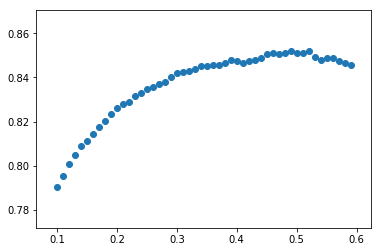

In [42]:
plt.scatter(np.arange(0.1,0.6,0.01), scores)
plt.show()

In [46]:
np.array(scores).argmax()

39

## Optimize threshold per class

In [52]:
def optim_threshold(y_true, y_pred):
    scores = []
    thrs = np.arange(0.01,0.9,0.01)
    for p in thrs:
        scores.append(f1_score(y_true, y_pred>p))
    return thrs[np.array(scores).argmax()]

In [53]:
thresholds = []
for i in range(val_true.shape[1]):
    thresholds.append(optim_threshold(val_true[:,i], prediction_val[:,i]))

In [55]:
prediction_val[:,0] > 0.5

array([ True, False,  True, ..., False, False,  True])

In [74]:
def apply_threshold(prediction, threshold):
    pred = np.stack([prediction[:,i] > threshold[i] for i in range(prediction.shape[1])])
    pred = pred.T
    for i in range(pred.shape[0]):
        lb = np.argwhere(pred[i,:])
        lb = list(lb.flatten())
        yield np.array(lb).flatten()

In [77]:
tmp = np.stack([prediction_val[:,i] > thresholds[i] for i in range(prediction_val.shape[1])]).T


In [78]:
f1_score(val_true, tmp, average='macro')

/opt/modules/i12g/anaconda/3-5.0.1/envs/hpaic/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5474321914951787

In [64]:
tmp = array2str(tmp)

In [66]:
tmp = list(tmp)

In [68]:
pred_labels = list(array2str(apply_threshold(prediction, thresholds)))

In [70]:
tst.Predicted = pred_labels
tst.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,3 5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25


In [71]:
tst.to_csv(DATA + "processed/Submission.csv", index=False)

(array([10115.,   473.,   190.,   117.,   104.,    83.,    87.,   100.,
          156.,   277.]),
 array([3.9458678e-06, 9.9830158e-02, 1.9965637e-01, 2.9948258e-01,
        3.9930877e-01, 4.9913499e-01, 5.9896117e-01, 6.9878739e-01,
        7.9861361e-01, 8.9843982e-01, 9.9826604e-01], dtype=float32),
 <a list of 10 Patch objects>)

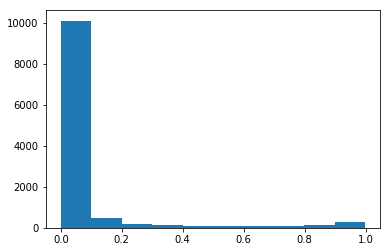

In [41]:
# def preds2label(preds, threshold=0):
#     ''' Convert prediction to multilabel
#     Args:
#         preds: prediction, default logits
#         threshod: 0 for logits, 0.5 for probs
#     '''
#     label = np.zeros(preds.shape)

#     for i in range(preds.shape[0]):
#         lb = np.argwhere(preds[i,:] > threshold)
#         yield np.array(lb).flatten()